## Practica 1 - Computer Vision

In [58]:
import os
import gdown

# Crear el directorio de datos si no existe
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL de Google Drive en formato correcto para gdown
url = "https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)

# Descargar el archivo
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)
else:
    print("Data zipfile already exists")


Data zipfile already exists


In [59]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

data_dir = "data"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)
subfolders = ["test", "train", "valid"]
full_paths = [os.path.join(data_dir, folder) for folder in subfolders]

if not all(os.path.isdir(path) for path in full_paths):
    with ZipFile(zip_path, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if not file.startswith("__MACOSX"):
                    exe.submit(zf.extract, file, path=data_dir)
else:
    print("test, train and valid folders already exist")

test, train and valid folders already exist


In [60]:
import pandas as pd
data_dir = "data"
df = pd.read_csv(os.path.join(data_dir, "test", "annotations.csv"))
print(f"{df.shape = }")
df.head()

df.shape = (584, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,406,457,497,533
1,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,18,705,82,759
2,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,51,426,116,475
3,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,428,331,504,376
4,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,0,613,21,658


In [61]:
import os
import pandas as pd
import numpy as np

def annotation_to_labels(annotations_path):
    # Load the annotations
    df = pd.read_csv(annotations_path)

    # Count the number of instances of each class per image
    count_class = df.groupby(["filename", "class"]).size()

    # Compute the area of each bounding box
    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

    # Compute the area of each class per image
    area_class = df.groupby(["filename", "class"])["area"].sum()

    # Compute the score as AREA * COUNT
    score = pd.Series(area_class * count_class, name="score").reset_index()

    # Group by filename and get the class with the highest score
    df_labels = score.groupby("filename").max().reset_index()

    return df_labels["filename"].values, df_labels["class"].values

data_dir = "data"
filenames, labels = annotation_to_labels(os.path.join(data_dir, "test", "annotations.csv"))
filenames[:5], labels[:5]

(array(['IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg',
        'IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg',
        'IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg',
        'IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg',
        'IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg'],
       dtype=object),
 array(['puffin', 'penguin', 'penguin', 'penguin', 'penguin'], dtype=object))

In [62]:
import shutil
def organize_by_label(filenames, labels, data_dir):
    # Define input and output paths
    filepaths = np.char.add(data_dir + os.sep, filenames)
    organized_filepaths = np.char.add(data_dir + os.sep + labels + os.sep, filenames)

    # Create a directory for each label
    for label in np.unique(labels):
        os.makedirs(data_dir + os.sep + label, exist_ok=True)

    # Move files to their respective directories
    def move_file(src, dest):
        try:
            shutil.move(src, dest)
            return True  # File moved successfully
        except FileNotFoundError:
            if not os.path.exists(dest):
                print(f"Annotated file not found: {src}")
            return False  # File does not exist
        except Exception as e:
            return f"Error: {e}"

    return np.vectorize(move_file)(filepaths, organized_filepaths)

set_names = ["train", "valid", "test"]
for set_name in set_names:
    data_dir = os.path.join("data", set_name)
    filenames, labels = annotation_to_labels(os.path.join(data_dir, "annotations.csv"))
    organize_by_label(filenames, labels, data_dir)

In [63]:
import tensorflow as tf

Example

In [64]:
data_dir = os.path.join("data", "test")
image_paths = tf.data.Dataset.list_files(
    data_dir + os.sep + '*/*.jpg',
    shuffle=False
)  # Note: Pattern only looks inside subfolders
print(image_paths.as_numpy_iterator().next())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'


## Create tf.data.Dataset

In [65]:
set_names = ["train", "valid", "test"]
data_dir = "data"
def get_jpg_ds(set_names, data_dir):
    return {
        name: tf.data.Dataset.list_files(
            os.path.join(data_dir, name) + os.sep + '*/*.jpg',
            shuffle=False,
        )
        for name in set_names
    }
ds = get_jpg_ds(set_names, data_dir)
ds

{'train': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'valid': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'test': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>}

In [66]:
next(ds["test"].as_numpy_iterator())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'

From our tensors that are image paths we extract labels, this is a light weight operation so we keep it in cache and perform all the normalization, that is, convert to onehot encoding

In [67]:
class_mapping = {
    0: b"fish",
    1: b"jellyfish",
    2: b"penguin",
    3: b"puffin",
    4: b"shark",
    5: b"starfish",
    6: b"stingray",
}

class_lookup_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(class_mapping.values())),
        values=tf.constant(list(class_mapping.keys()), dtype=tf.int64)
    ),
    default_value=-1
)

def get_label(image_path):
    label = tf.strings.split(image_path, os.sep)[-2]
    label = class_lookup_table.lookup(label)
    label = tf.one_hot(label, len(class_mapping))
    return label

def update_ds(ds, func):
    for key in ds.keys():
        ds[key] = ds[key].map(
            func,
            num_parallel_calls=tf.data.AUTOTUNE
        )

set_names = ["train", "valid", "test"]
data_dir = "data"

ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))

ds["test"].as_numpy_iterator().next()

(b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg',
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [68]:
def get_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [69]:
ds["train"]

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

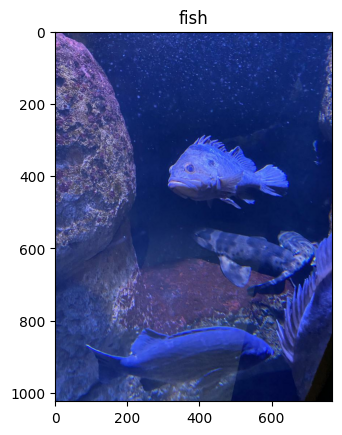

In [70]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [71]:
ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

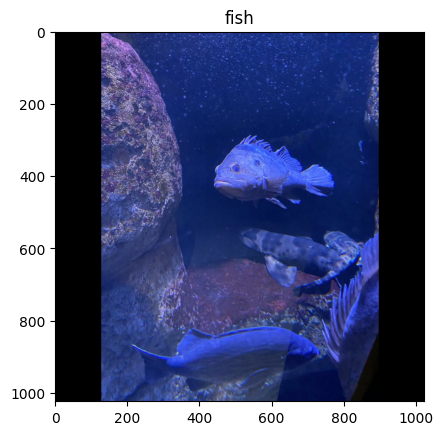

In [72]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [73]:
def resize_and_keep_uint8(image, height=64, width=64):
    resized_image = tf.image.resize(image, [height, width])  # Resize
    resized_image = tf.clip_by_value(resized_image, 0, 255)  # Ensure values remain valid
    resized_image = tf.cast(resized_image, tf.uint8)  # Convert back to uint8
    return resized_image

ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [74]:
def standardize_image(image, label):
    image = tf.cast(image, tf.float32)
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    image = (image - mean) / (std + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero
    return image, label

update_ds(ds, lambda x, y: (standardize_image(x, y)))

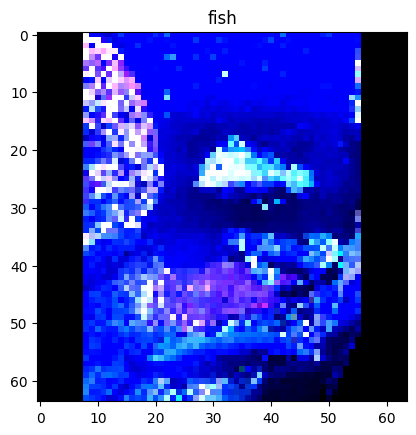

In [75]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [76]:
ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [77]:
print(len(ds["train"]), len(ds["valid"]))

def augment(image,label):
    image = tf.image.random_flip_left_right(image) # Random flip horizontal
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
ds_fit = (
    ds["train"]
    .cache()
    .map(augment, num_parallel_calls=AUTOTUNE)
    .shuffle(len(ds["train"]))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds["valid"]
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

447 127


In [78]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 10
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=epoch_wait, restore_best_weights=True)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [79]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam

num_classes = 7
IMG_SIZE = 64
l2_reg_strength = 0.01

# Modelo base con MobileNetV3Large
base_model = MobileNetV3Large(input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet')
base_model.trainable = False

# Modelo 1 - Learning rate alto (0.001)
model1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modelo 2 - Learning rate medio (0.0005)
model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modelo 3 - Learning rate bajo (0.0001)
model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento de los modelos
history1 = model1.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)
history2 = model2.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)
history3 = model3.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 379ms/step - accuracy: 0.2985 - loss: 1.7532 - val_accuracy: 0.4803 - val_loss: 1.3424 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.7003 - loss: 0.8916 - val_accuracy: 0.6063 - val_loss: 1.1707 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8233 - loss: 0.6313 - val_accuracy: 0.6378 - val_loss: 1.1027 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9201 - loss: 0.3931 - val_accuracy: 0.6693 - val_loss: 1.0706 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9587 - loss: 0.2651 - val_accuracy: 0.6614 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9802 - loss: 0.1911 - val_accuracy: 0.6850 - val_loss: 1.0709 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9960 - loss: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


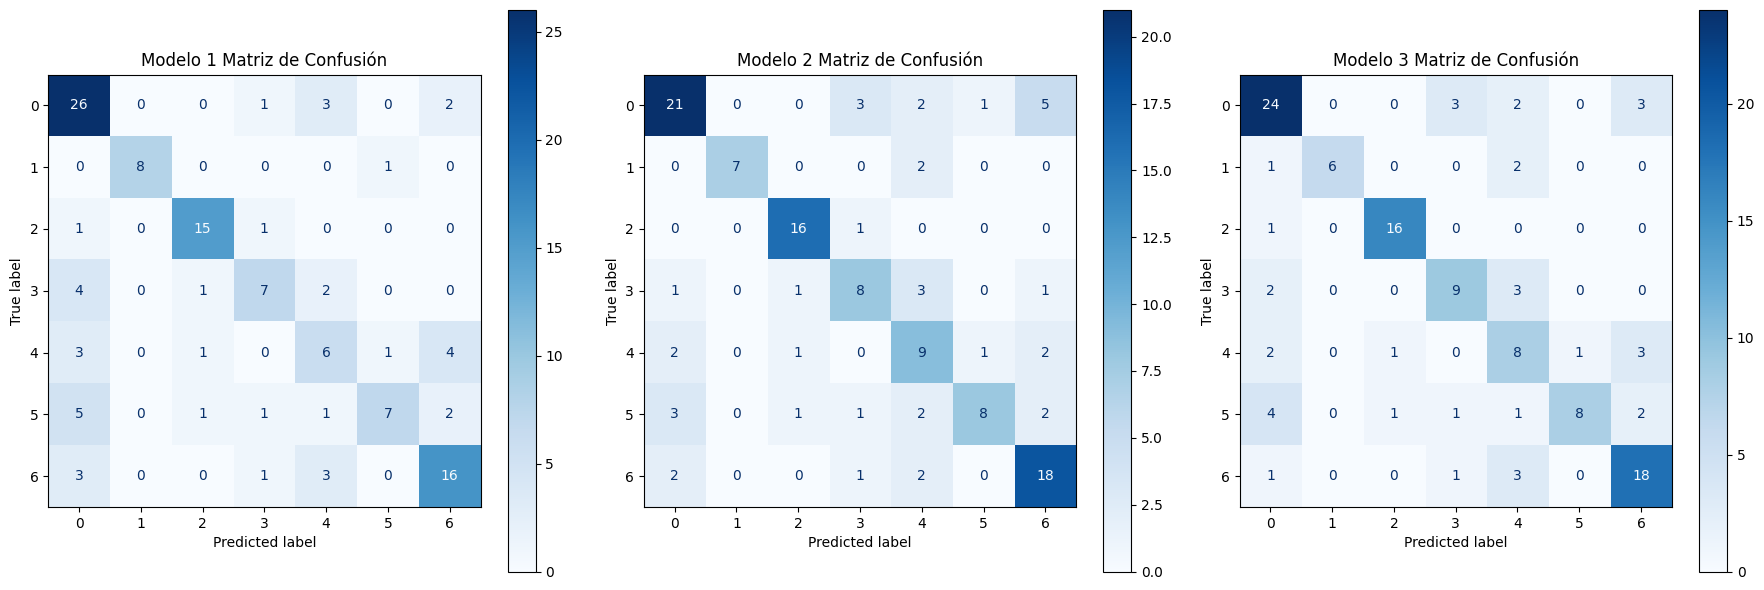

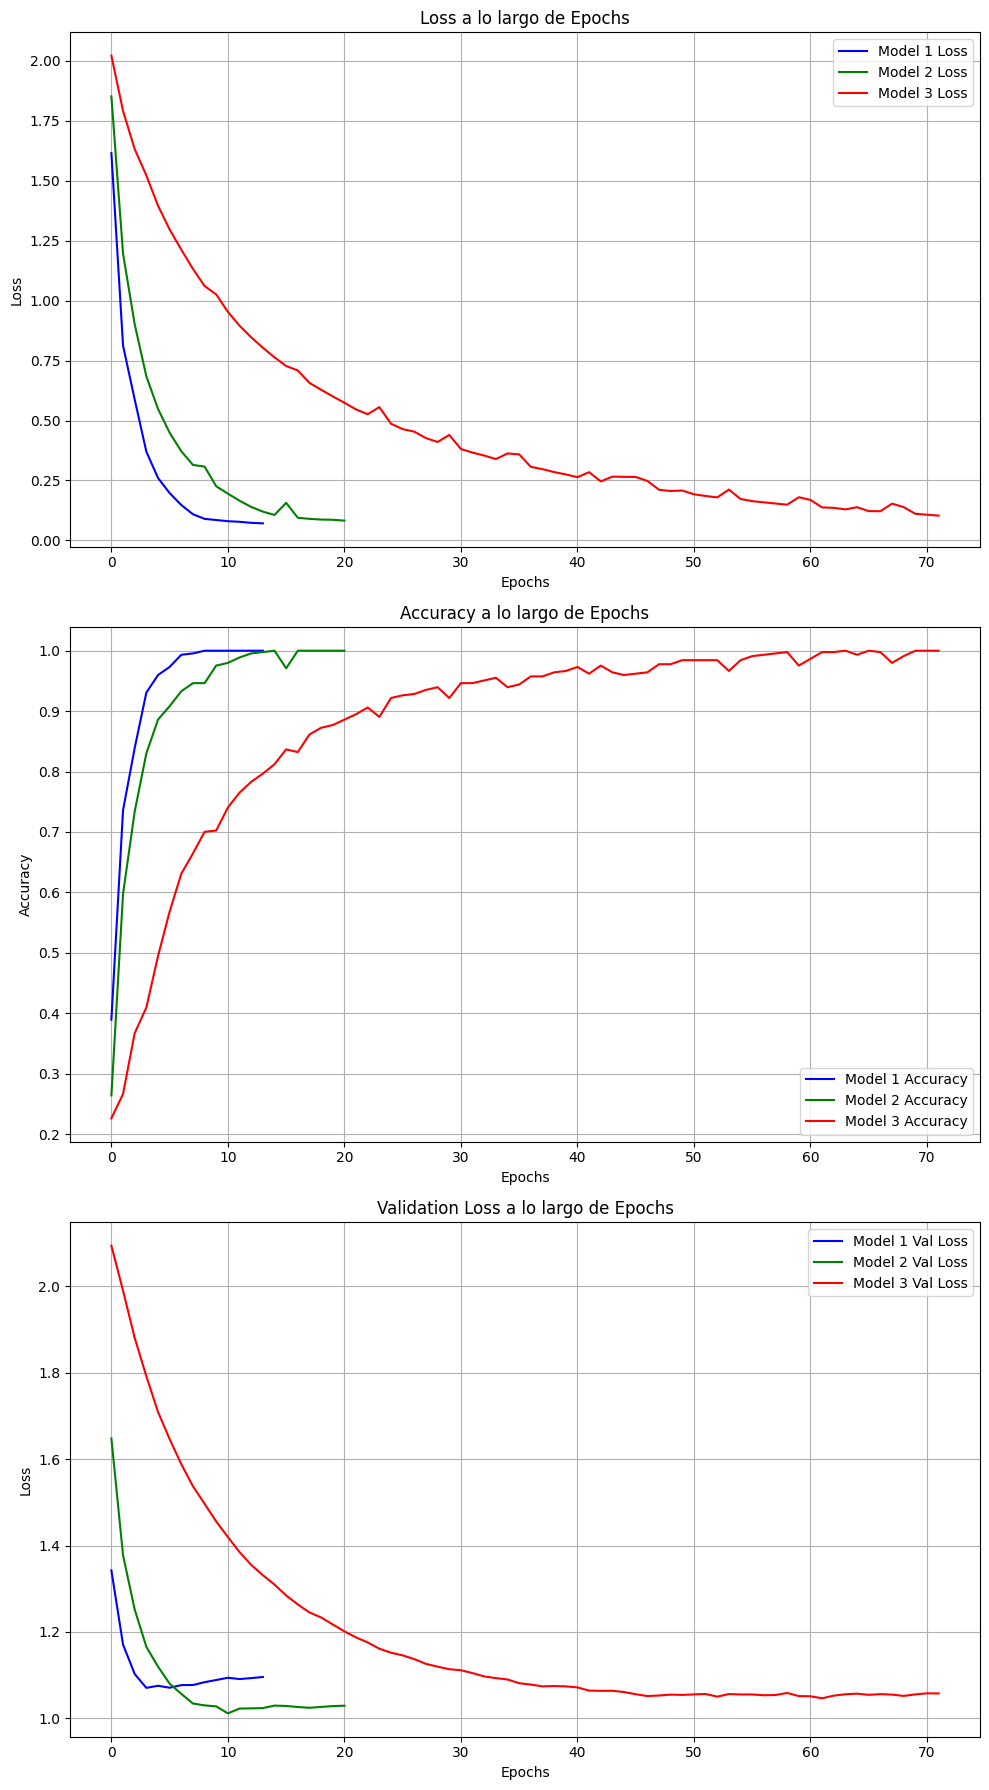

Métricas para Modelo 1:
Accuracy: 0.6693
Precision: 0.6806
Recall: 0.6693
F1 Score: 0.6628
------------------------------
Métricas para Modelo 2:
Accuracy: 0.6850
Precision: 0.7057
Recall: 0.6850
F1 Score: 0.6854
------------------------------
Métricas para Modelo 3:
Accuracy: 0.7008
Precision: 0.7276
Recall: 0.7008
F1 Score: 0.7015
------------------------------


In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf

# Obtener predicciones de los modelos para el conjunto de validación
y_pred1 = np.argmax(model1.predict(ds_val), axis=1)
y_pred2 = np.argmax(model2.predict(ds_val), axis=1)
y_pred3 = np.argmax(model3.predict(ds_val), axis=1)

# Obtener etiquetas verdaderas del conjunto de validación
# Esto depende de cómo esté estructurado tu conjunto de datos
y_true = []
for x, y in ds_val:
    y_true.extend(np.argmax(y.numpy(), axis=1))
y_true = np.array(y_true)

# Calcular matrices de confusión
cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)
cm3 = confusion_matrix(y_true, y_pred3)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
disp1 = ConfusionMatrixDisplay(cm1).plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Modelo 1 Matriz de Confusión')
disp2 = ConfusionMatrixDisplay(cm2).plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Modelo 2 Matriz de Confusión')
disp3 = ConfusionMatrixDisplay(cm3).plot(ax=axes[2], cmap='Blues', values_format='d')
axes[2].set_title('Modelo 3 Matriz de Confusión')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Visualizar curvas de pérdida
axs[0].plot(history1.history['loss'], label='Model 1 Loss', color='blue')
axs[0].plot(history2.history['loss'], label='Model 2 Loss', color='green')
axs[0].plot(history3.history['loss'], label='Model 3 Loss', color='red')
axs[0].set_title('Loss a lo largo de Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Visualizar curvas de precisión
axs[1].plot(history1.history['accuracy'], label='Model 1 Accuracy', color='blue')
axs[1].plot(history2.history['accuracy'], label='Model 2 Accuracy', color='green')
axs[1].plot(history3.history['accuracy'], label='Model 3 Accuracy', color='red')
axs[1].set_title('Accuracy a lo largo de Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

# Visualizar curvas de pérdida de validación
axs[2].plot(history1.history['val_loss'], label='Model 1 Val Loss', color='blue')
axs[2].plot(history2.history['val_loss'], label='Model 2 Val Loss', color='green')
axs[2].plot(history3.history['val_loss'], label='Model 3 Val Loss', color='red')
axs[2].set_title('Validation Loss a lo largo de Epochs')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

# Calcular y mostrar métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Función para calcular y mostrar métricas
def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Métricas para {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)

print_metrics(y_true, y_pred1, "Modelo 1")
print_metrics(y_true, y_pred2, "Modelo 2")
print_metrics(y_true, y_pred3, "Modelo 3")